In [1]:
#obtendo dados da api gutendex books
import requests

url = 'https://gutendex.com/books?'

response = requests.get(url)

data = response.json()

In [2]:
#analisando estrutura dos dados
import json
print(json.dumps(data, indent=2))

{
  "count": 74608,
  "next": "https://gutendex.com/books/?page=2",
  "previous": null,
  "results": [
    {
      "id": 84,
      "title": "Frankenstein; Or, The Modern Prometheus",
      "authors": [
        {
          "name": "Shelley, Mary Wollstonecraft",
          "birth_year": 1797,
          "death_year": 1851
        }
      ],
      "translators": [],
      "subjects": [
        "Frankenstein's monster (Fictitious character) -- Fiction",
        "Frankenstein, Victor (Fictitious character) -- Fiction",
        "Gothic fiction",
        "Horror tales",
        "Monsters -- Fiction",
        "Science fiction",
        "Scientists -- Fiction"
      ],
      "bookshelves": [
        "Browsing: Culture/Civilization/Society",
        "Browsing: Fiction",
        "Browsing: Gender & Sexuality Studies",
        "Browsing: Literature",
        "Browsing: Science-Fiction & Fantasy",
        "Gothic Fiction",
        "Movie Books",
        "Precursors of Science Fiction",
        "Scie

In [3]:
#transformando json em um dataset utilizando pandas
import pandas as pd
df = pd.DataFrame(data['results'])
df.head()

,id,title,authors,translators,subjects,bookshelves,languages,copyright,media_type,formats,download_count
0,84,"Frankenstein; Or, The Modern Prometheus","[{'name': 'Shelley, Mary Wollstonecraft', 'bir...",[],[Frankenstein's monster (Fictitious character)...,"[Browsing: Culture/Civilization/Society, Brows...",[en],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,174761
1,2701,"Moby Dick; Or, The Whale","[{'name': 'Melville, Herman', 'birth_year': 18...",[],"[Adventure stories, Ahab, Captain (Fictitious ...","[Best Books Ever Listings, Browsing: Fiction, ...",[en],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,74858
2,1513,Romeo and Juliet,"[{'name': 'Shakespeare, William', 'birth_year'...",[],"[Conflict of generations -- Drama, Juliet (Fic...","[Browsing: Fiction, Browsing: Literature, Brow...",[en],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,62300
3,1342,Pride and Prejudice,"[{'name': 'Austen, Jane', 'birth_year': 1775, ...",[],"[Courtship -- Fiction, Domestic fiction, Engla...","[Best Books Ever Listings, Browsing: Culture/C...",[en],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,58812
4,25344,The Scarlet Letter,"[{'name': 'Hawthorne, Nathaniel', 'birth_year'...",[],"[Adultery -- Fiction, Boston (Mass.) -- Histor...","[Banned Books from Anne Haight's list, Browsin...",[en],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,54994


In [4]:
#tratar os dados na coluna 'authors'
df_exploded = df.explode("authors")

authors_df = pd.json_normalize(df_exploded["authors"])

df = df_exploded.drop(columns=["authors"]).reset_index(drop=True)
df = pd.concat([df, authors_df], axis=1)

In [5]:
df['seculo'] = (df['birth_year'] // 100) * 100

In [6]:
#tratar os dados da coluna 'translators'
df_exploded = df.explode('translators')

authors_df = pd.json_normalize(df_exploded['translators'])
authors_df['translator_name'] = authors_df['name']

df = df_exploded.drop(columns=['translators']).reset_index(drop=True)
df = pd.concat([df, authors_df['translator_name']], axis=1)

In [7]:
df['translation_status'] = df['translator_name'].isna().map({True: 'Not translated', False: 'Translated'})

In [8]:
#tratar os dados da coluna 'languages'
df = df.explode('languages')

In [9]:
#função para analisar os dados de 'subjects' e definir um genero para o livro
def determine_genre(categories, common_genres):
    if isinstance(categories, str):
        categories = [categories]
    
    common_genres_set = set(genre.lower() for genre in common_genres)
    
    for category in categories:
        words = category.split()
        for word in words:
            if word.lower() in common_genres_set:
                return word.capitalize()
    
    return "Unknown"

common_genres = ["Fiction", "History", "Fantasy", "Mystery", "Romance", "Thriller", "Biography", "Drama", "Adventure", "Humour", "Satire", "Poetry", "Politics"]

In [10]:
#gerando a coluna 'genre' no dataframe com o genero do livro
generos = []
for i in range(len(df)):
    generos.append(determine_genre(df_exploded['subjects'][i], common_genres))

df['genre'] = pd.DataFrame(generos)
df.drop(['bookshelves', 'languages', 'copyright', 'media_type', 'subjects', 'formats','death_year','birth_year','translator_name'], axis=1, inplace=True)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
#livros mais baixados
df[['title', 'name', 'download_count', 'genre']].sort_values(by='download_count', ascending=False)[:5]

,title,name,download_count,genre
0,"Frankenstein; Or, The Modern Prometheus","Shelley, Mary Wollstonecraft",174761,Fiction
1,"Moby Dick; Or, The Whale","Melville, Herman",74858,Adventure
2,Romeo and Juliet,"Shakespeare, William",62300,Drama
3,Pride and Prejudice,"Austen, Jane",58812,Fiction
4,The Scarlet Letter,"Hawthorne, Nathaniel",54994,Fiction


In [13]:
#livros menos baixados
df[['title', 'name', 'download_count', 'genre']].sort_values(by='download_count')[:5]

,title,name,download_count,genre
32,The Brothers Karamazov,"Dostoyevsky, Fyodor",18938,Fiction
31,Beowulf: An Anglo-Saxon Epic Poem,NaN,19579,Poetry
30,A Modest Proposal: For preventing the children...,"Swift, Jonathan",19971,Politics
29,The Picture of Dorian Gray,"Wilde, Oscar",21127,Fiction
28,Dracula,"Stoker, Bram",22060,Fiction


In [14]:
#artistas com livros mais baixados
grouped = df[['name', 'download_count', 'genre']].groupby('name').sum().sort_values(by='download_count',ascending=False)
grouped[:5]

,download_count,genre
name,,
"Shelley, Mary Wollstonecraft",174761,Fiction
"Smollett, T. (Tobias)",113544,AdventureFictionFiction
"Shakespeare, William",100962,DramaDrama
"Melville, Herman",74858,Adventure
"Austen, Jane",58812,Fiction


In [15]:
#artistas com livros mais baixados
grouped = df[['name', 'download_count', 'genre']].groupby('name').sum().sort_values(by='download_count')
grouped[:5]

,download_count,genre
name,,
"Swift, Jonathan",19971,Politics
"Wilde, Oscar",21127,Fiction
"Stoker, Bram",22060,Fiction
"Fitzgerald, F. Scott (Francis Scott)",22408,Fiction
"Hobbes, Thomas",23163,Unknown


<Axes: xlabel='genre', ylabel='download_count'>

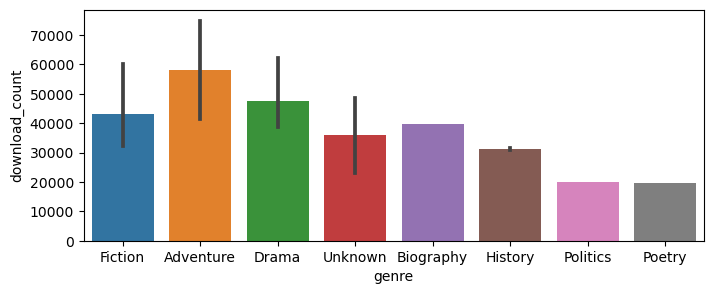

In [16]:
#grafico de barras que mostra os livros mais baixados por genero
plt.figure(figsize=(8,3))
sns.barplot(x=df['genre'], y=df['download_count'])

<Axes: xlabel='translation_status', ylabel='download_count'>

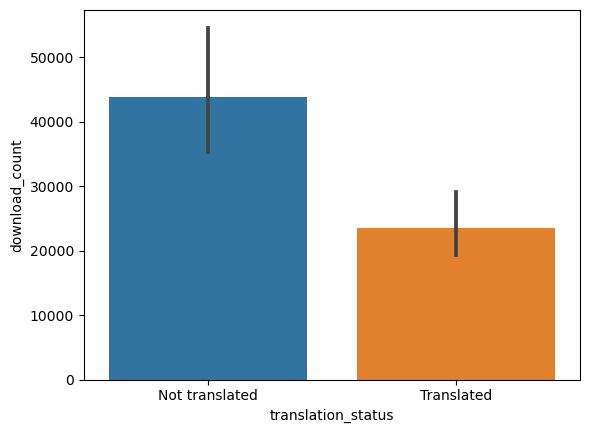

In [17]:
#grafico de barras que compara livros traduzidos e nao traduzidos
sns.barplot(x=df['translation_status'], y=df['download_count'])

<Axes: xlabel='seculo', ylabel='download_count'>

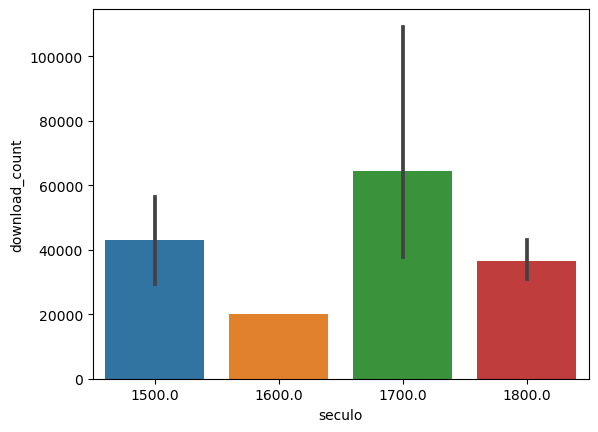

In [18]:
#grafico de barras que compara quantidade de downloads do livro com ano de nascimento do autor
sns.barplot(x=df['seculo'],y=df['download_count'])